## Searching for bouts for a day of alsa recording

In [1]:
%matplotlib inline
import os
import glob
import socket
import logging
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt

from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.info('Running on {}'.format(socket.gethostname()))

2021-07-21 12:13:09,271 root         INFO     Running on pakhi


In [2]:
from ceciestunepipe.file import bcistructure as et

### Get the file locations for a session (day) of recordings

In [18]:
reload(et)
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-10'}


exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='alsa')

raw_folder = exp_struct['folders']['alsa']

In [19]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-10',
 'alsa': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-10/alsa',
 'kwik': '/scratch/earneodo/s_b1253_21/alsa/kwik/2021-06-10',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-10/alsa',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-10/alsa',
 'tmp': '/scratch/earneodo/tmp',
 'msort': '/scratch/earneodo/s_b1253_21/alsa/msort/2021-06-10',
 'ksort': '/scratch/earneodo/s_b1253_21/alsa/ksort/2021-06-10'}

#### search parameters
Spectrograms are computed using librosa

Additional parameters are for bout search criteria and functions to read the data

In [20]:
# function for getting one channel out of a wave file
def read_wav_chan(wav_path: str, chan_id: int=0) -> tuple:
    s_f, x = wavfile.read(wav_path, mmap=True)
    return s_f, x[:, chan_id]

def sess_file_id(f_path):
    n = int(os.path.split(f_path)[1].split('-')[-1].split('.wav')[0])
    return n

hparams = {
    # spectrogram
    'num_freq':1024, #1024# how many channels to use in a spectrogram #
    'preemphasis':0.97, 
    'frame_shift_ms':5, # step size for fft
    'frame_length_ms':10, #128 # frame length for fft FRAME SAMPLES < NUM_FREQ!!!
    'min_level_db':-55, # minimum threshold db for computing spe 
    'ref_level_db':110, # reference db for computing spec
    'sample_rate':None, # sample rate of your data
    
    # spectrograms
    'mel_filter': False, # should a mel filter be used?
    'num_mels':1024, # how many channels to use in the mel-spectrogram
    'fmin': 500, # low frequency cutoff for mel filter
    'fmax': 12000, # high frequency cutoff for mel filter
    
    # spectrogram inversion
    'max_iters':200,
    'griffin_lim_iters':20,
    'power':1.5,

    # Added for the searching
    'read_wav_fun': read_wav_chan, # function for loading the wav_like_stream (has to returns fs, ndarray)
    'file_order_fun': sess_file_id, # function for extracting the file id within the session
    'min_segment': 30, # Minimum length of supra_threshold to consider a 'syllable' (ms)
    'min_silence': 2000, # Minmum distance between groups of syllables to consider separate bouts (ms)
    'min_bout': 5000, # min bout duration (ms)
    'peak_thresh_rms': 0.55, # threshold (rms) for peak acceptance,
    'thresh_rms': 0.25, # threshold for detection of syllables
    'mean_syl_rms_thresh': 0.3, #threshold for acceptance of mean rms across the syllable (relative to rms of the file)
    'max_bout': 120000, #exclude bouts too long
    'l_p_r_thresh': 100, # threshold for n of len_ms/peaks (typycally about 2-3 syllable spans
    
    'waveform_edges': 1000, #get number of ms before and after the edges of the bout for the waveform sample
    
    'bout_auto_file': 'bout_auto.pickle', # extension for saving the auto found files
    'bout_curated_file': 'bout_checked.pickle', #extension for manually curated files (coming soon)
    }

#### Get one wave file

In [21]:
one_wav_path = os.path.join(exp_struct['folders']['alsa'], '07-00-01-02.wav')

s_f, x = read_wav_chan(one_wav_path)

hparams['sample_rate'] = s_f

In [22]:
x.shape

(81600000,)

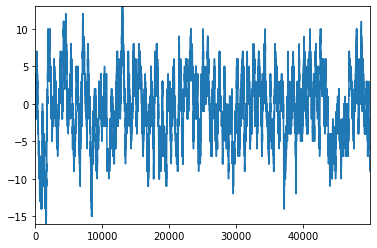

In [23]:
plt.plot(x[:50000])

### try the function to search for bouts in the file

In [24]:
from ceciestunepipe.util.sound import boutsearch as bs

In [10]:
bpd, x, p = bs.get_bouts_in_file(one_wav_path, hparams)

2021-07-21 12:13:19,377 ceciestunepipe.util.sound.boutsearch INFO     Getting bouts for file /mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-21/alsa/07-00-01-02.wav


tu vieja file /mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-21/alsa/07-00-01-02.wav


In [24]:
bpd

""


In [12]:
plt.plot(bpd['waveform'].values[0])

KeyError: 'waveform'

In [25]:
bpd

""


In [26]:
hparams

{'num_freq': 1024,
 'preemphasis': 0.97,
 'frame_shift_ms': 5,
 'frame_length_ms': 10,
 'min_level_db': -55,
 'ref_level_db': 110,
 'sample_rate': 48000,
 'mel_filter': False,
 'num_mels': 1024,
 'fmin': 500,
 'fmax': 12000,
 'max_iters': 200,
 'griffin_lim_iters': 20,
 'power': 1.5,
 'read_wav_fun': <function __main__.read_wav_chan(wav_path: str, chan_id: int = 0) -> tuple>,
 'file_order_fun': <function __main__.sess_file_id(f_path)>,
 'min_segment': 30,
 'min_silence': 2000,
 'min_bout': 5000,
 'peak_thresh_rms': 0.55,
 'thresh_rms': 0.25,
 'mean_syl_rms_thresh': 0.3,
 'max_bout': 120000,
 'l_p_r_thresh': 100,
 'waveform_edges': 1000,
 'bout_auto_file': 'bout_auto.pickle',
 'bout_curated_file': 'bout_checked.pickle'}

### get all bouts of the day

In [25]:
from joblib import Parallel, delayed

In [26]:
reload(bs)

<module 'ceciestunepipe.util.sound.boutsearch' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/sound/boutsearch.py'>

In [28]:
def get_all_day_bouts(sess_par: dict, hparams:dict, n_jobs: int=12) -> pd.DataFrame:
    
    logger.info('Will search for bouts through all session {}, {}'.format(sess_par['bird'], sess_par['sess']))
    exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='alsa')

    # get all the paths to the wav files of the day
    raw_folder = exp_struct['folders']['alsa']
    wav_path_list = glob.glob(os.path.join(exp_struct['folders']['alsa'], '*.wav'))
    wav_path_list.sort()
    logger.info('Found {} files'.format(len(wav_path_list)))
    
    def get_file_bouts(i_path):
        return bs.get_bouts_in_file(i_path, hparams)[0]
    
    # Go parallel through all the paths in the day, get a list of all the pandas dataframes for each file
    sess_pd_list = Parallel(n_jobs=n_jobs, verbose=100, backend=None)(delayed(get_file_bouts)(i) for i in wav_path_list)
    
    #sess_pd_list = [bs.get_bouts_in_file(i, hparams)[0] for i in wav_path_list]
    
    # concatenate the file and return it, eventually write to a pickle
    sess_bout_pd = pd.concat(sess_pd_list)
    return sess_bout_pd

sess_bout_pd = get_all_day_bouts(sess_par, hparams, n_jobs=28)

2021-07-21 12:33:20,346 root         INFO     Will search for bouts through all session s_b1253_21, 2021-06-10
2021-07-21 12:33:20,349 root         INFO     Found 26 files


[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=28)]: Done   2 out of  26 | elapsed:  1.5min remaining: 18.4min
[Parallel(n_jobs=28)]: Done   3 out of  26 | elapsed:  1.5min remaining: 11.8min
[Parallel(n_jobs=28)]: Done   4 out of  26 | elapsed:  1.6min remaining:  9.0min
[Parallel(n_jobs=28)]: Done   5 out of  26 | elapsed:  1.6min remaining:  6.9min
[Parallel(n_jobs=28)]: Done   6 out of  26 | elapsed:  1.7min remaining:  5.5min
[Parallel(n_jobs=28)]: Done   7 out of  26 | elapsed:  1.7min remaining:  4.5min
[Parallel(n_jobs=28)]: Done   8 out of  26 | elapsed:  1.7min remaining:  3.8min
[Parallel(n_jobs=28)]: Done   9 out of  26 | elapsed:  1.7min remaining:  3.2min
[Parallel(n_jobs=28)]: Done  10 out of  26 | elapsed:  1.7min remaining:  2.7min
[Parallel(n_jobs=28)]: Done  11 out of  26 | elapsed:  1.7min remaining:  2.3min
[Parallel(n_jobs=28)]: Done  12 out of  26 | elapse

In [34]:
import sys
sys.stdout.flush()

In [35]:
sess_bout_pd.shape

(3, 16)

### save the pandas for the day as a pickle

In [36]:
import pickle
import sys

In [37]:
def save_auto_bouts(sess_bout_pd, sess_par, hparams):
    exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='alsa')
    sess_bouts_dir = os.path.join(exp_struct['folders']['derived'], 'bouts_ceciestunepipe')

    sess_bouts_path = os.path.join(sess_bouts_dir, hparams['bout_auto_file'])
    hparams_pickle_path = os.path.join(sess_bouts_dir, 'bout_search_params.pickle')

    os.makedirs(sess_bouts_dir, exist_ok=True)
    logger.info('saving bouts pandas to ' + sess_bouts_path)
    sess_bout_pd.to_pickle(sess_bouts_path)

    logger.info('saving bout detect parameters dict to ' + hparams_pickle_path)
    with open(hparams_pickle_path, 'wb') as fh:
        pickle.dump(hparams, fh)
        
save_auto_bouts(sess_bout_pd, sess_par, hparams)

2021-07-21 18:50:10,720 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-21/alsa/bouts_ceciestunepipe/bout_auto.pickle
2021-07-21 18:50:10,747 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-21/alsa/bouts_ceciestunepipe/bout_search_params.pickle


In [38]:
sess_bout_pd.head(1)

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,syl_in,n_syl,peaks_p,n_peaks,l_p_ratio,waveform
0,1290805,1299255,61958640,62364240,"[0.6991527317204725, 12.869607543970698, 16.55...",1.462951,122.930425,True,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,8450,"[[1290805, 1290845], [1291020, 1291065], [1291...",16,"[4, 19, 30, 47, 60, 72, 88, 109, 122, 136, 149...",82,103.04878,"[-12, -14, -16, -11, -12, -15, -11, -12, -14, ..."


### save the bouts of a pandas as wavs

In [39]:
bird_bouts_folder = os.path.abspath('/mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav')
bird_bouts_folder

'/mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav'

In [40]:
os.makedirs(bird_bouts_folder, exist_ok=True)

In [41]:
a_bout = sess_bout_pd.iloc[0]

In [42]:
a_bout['file']

'/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-21/alsa/10-00-01-01.wav'

In [43]:
def bout_to_wav(a_bout: pd.Series, sess_par, hparams, dest_dir):
    file_name = '{}_{}_{}.wav'.format(sess_par['sess'],
                                      os.path.split(a_bout['file'])[-1].split('.wav')[0],
                                      a_bout['start_ms'])
    file_path = os.path.join(dest_dir, file_name)
    x = a_bout['waveform']
    
    wavfile.write(file_path, hparams['sample_rate'], x)
    return file_path                                                      
    
def bouts_to_wavs(sess_bout_pd, sess_par, hparams, dest_dir):
    # make the dest_dir if does not exist
    logger.info('Saving all session bouts to folder ' + dest_dir)
    os.makedirs(dest_dir, exist_ok=True)
    # write all the motifs to wavs
    sess_bout_pd.apply(lambda x: bout_to_wav(x, sess_par, hparams, dest_dir), axis=1)
    # write the hparams as pickle
    hparams_pickle_path = os.path.join(dest_dir, 'bout_search_params_{}.pickle'.format(sess_par['sess']))
    
    logger.info('saving bout detect parameters dict to ' + hparams_pickle_path)
    with open(hparams_pickle_path, 'wb') as fh:
        pickle.dump(hparams, fh)
    
# one example
sess_bouts_folder = os.path.join(bird_bouts_folder, sess_par['sess'])
os.makedirs(sess_bouts_folder, exist_ok=True)
#bout_to_wav(a_bout, sess_par, hparams, bout_folder)

# all the bouts in the sess
#bouts_to_wavs(sess_bout_pd, sess_par, hparams, bird_bouts_folder)

## Run this for all sessions of the bird with alsa recordings

#### list all sessions

In [44]:
reload(et)

<module 'ceciestunepipe.file.bcistructure' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/file/bcistructure.py'>

In [60]:
all_sessions = et.list_sessions(sess_par['bird'], section='raw', ephys_software='alsa')
all_sessions.sort()
all_sessions

['2021-05-12',
 '2021-05-20',
 '2021-05-21',
 '2021-05-22',
 '2021-05-23',
 '2021-05-24',
 '2021-05-25',
 '2021-05-26',
 '2021-05-27',
 '2021-05-28',
 '2021-05-29',
 '2021-05-30',
 '2021-05-31',
 '2021-06-01',
 '2021-06-02',
 '2021-06-03',
 '2021-06-04',
 '2021-06-05',
 '2021-06-06',
 '2021-06-07',
 '2021-06-08',
 '2021-06-09',
 '2021-06-10',
 '2021-06-11',
 '2021-06-12',
 '2021-06-13',
 '2021-06-14',
 '2021-06-15',
 '2021-06-16',
 '2021-06-17',
 '2021-06-18',
 '2021-06-19',
 '2021-06-20',
 '2021-06-21',
 '2021-06-22',
 '2021-06-23',
 '2021-06-24',
 '2021-06-25',
 '2021-06-26',
 '2021-06-27',
 '2021-06-28',
 '2021-06-29',
 '2021-06-30',
 '2021-07-01',
 '2021-07-02',
 '2021-07-03',
 '2021-07-04',
 '2021-07-05',
 '2021-07-06',
 '2021-07-07',
 '2021-07-08',
 '2021-07-09',
 '2021-07-10',
 '2021-07-11',
 '2021-07-12',
 '2021-07-13',
 '2021-07-14',
 '2021-07-15',
 '2021-07-16',
 '2021-07-17',
 '2021-07-18',
 '2021-07-19',
 '2021-07-20',
 '2021-07-21',
 '2021-07-22',
 '2021-07-23',
 '2021-07-

In [61]:
all_sessions[-1:]

['2021-07-25']

In [62]:
for sess in all_sessions[-1:]:
    try:
        sess_par['sess'] = sess
        sess_bout_pd = get_all_day_bouts(sess_par, hparams, n_jobs=28)
        save_auto_bouts(sess_bout_pd, sess_par, hparams)
        sess_bouts_folder = os.path.join(bird_bouts_folder, sess)
        bouts_to_wavs(sess_bout_pd, sess_par, hparams, sess_bouts_folder)
    except:
        logger.info('Something went wrong in session ' + sess)
        logger.info('Error {}'.format(sys.exc_info()[0]))
        

2021-07-26 06:46:21,991 root         INFO     Will search for bouts through all session s_b1253_21, 2021-07-25
2021-07-26 06:46:22,262 root         INFO     Found 28 files


[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   1 tasks      | elapsed: 15.4min
[Parallel(n_jobs=28)]: Done   2 out of  28 | elapsed: 15.9min remaining: 206.8min
[Parallel(n_jobs=28)]: Done   3 out of  28 | elapsed: 15.9min remaining: 132.7min
[Parallel(n_jobs=28)]: Done   4 out of  28 | elapsed: 16.6min remaining: 99.6min
[Parallel(n_jobs=28)]: Done   5 out of  28 | elapsed: 16.6min remaining: 76.4min
[Parallel(n_jobs=28)]: Done   6 out of  28 | elapsed: 18.6min remaining: 68.3min
[Parallel(n_jobs=28)]: Done   7 out of  28 | elapsed: 18.6min remaining: 55.9min
[Parallel(n_jobs=28)]: Done   8 out of  28 | elapsed: 18.6min remaining: 46.6min
[Parallel(n_jobs=28)]: Done   9 out of  28 | elapsed: 18.7min remaining: 39.4min
[Parallel(n_jobs=28)]: Done  10 out of  28 | elapsed: 18.7min remaining: 33.6min
[Parallel(n_jobs=28)]: Done  11 out of  28 | elapsed: 18.7min remaining: 28.9min
[Parallel(n_jobs=28)]: Done  12 out of  28 | elap

2021-07-26 07:05:28,723 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-25/alsa/bouts_ceciestunepipe/bout_auto.pickle


[Parallel(n_jobs=28)]: Done  28 out of  28 | elapsed: 19.1min remaining:    0.0s
[Parallel(n_jobs=28)]: Done  28 out of  28 | elapsed: 19.1min finished


2021-07-26 07:05:43,146 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-25/alsa/bouts_ceciestunepipe/bout_search_params.pickle
2021-07-26 07:05:43,513 root         INFO     Saving all session bouts to folder /mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav/2021-07-25
2021-07-26 07:05:44,844 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav/2021-07-25/bout_search_params_2021-07-25.pickle
